# STEP 2 : image segmentation  
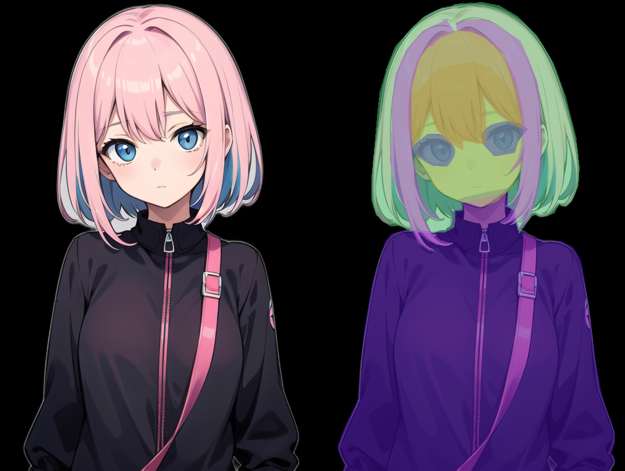

**GOAL**: create masks with most important for animations features (face, body, hair+parts, eyes) to cut pictures

### imports

In [1]:
!pip install torch

In [2]:
pip install scikit-image

Note: you may need to restart the kernel to use updated packages.


In [3]:
!pip install imgaug --user

In [4]:
import os
import glob
import cv2
from PIL import Image
import numpy as np
import matplotlib as plt
import imgaug.augmenters as iaa

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

F:\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras import layers, Model
import tensorflow as tf
from keras.utils import normalize
from keras.optimizers import Adam
from keras.utils import to_categorical

In [6]:
# const
#BATCH_SIZE = 16
IMG_SHAPE  = (384, 256)
OUTPUT_SIZE = (384, 256)
CLASSES = 7
RANDOM_STATE = 42

## Dataset

My Dataset consists of 50 images, manualy labeled into 7 classes:  
+ background  
1. body (<span style="color:purple">purple</span>)
2. head (<span style="color:gold">yellow</span>)
3. hair_main (<span style="color:green">green</span>)
4. hair_bangs (<span style="color:orange">orange</span>)
5. hair_front (<span style="color:pink">pink</span>)
6. eyes (<span style="color:blue">blue</span>)

I used [Supervisely](https://app.supervisely.com/projects/298168/datasets/940707) as a labeling tool.  

Ill convert my images to gray for easier computation


In [7]:
# images
train_images=[]

for directory_path in glob.glob(r'path'):
    for img_path in glob.glob(os.path.join(directory_path, "*.png")):
        img = cv2.imread(img_path, 0)       
        train_images.append(img)

In [8]:
# Convert list to array for machine learning processing
train_images=np.array(train_images)

In [9]:
# mask/label info as a list
train_masks = [] 

for directory_path in glob.glob(r'path'):
    for mask_path in glob.glob(os.path.join(directory_path, "*.png")):
        mask = cv2.imread(mask_path, 0)       
        train_masks.append(mask)

In [10]:
train_masks = np.array(train_masks)

In [11]:
np.unique(train_masks)

array([0, 1, 2, 3, 4, 5, 6], dtype=uint8)

In [12]:
display(train_images.shape,
       train_masks.shape)

(50, 768, 512)

(50, 768, 512)

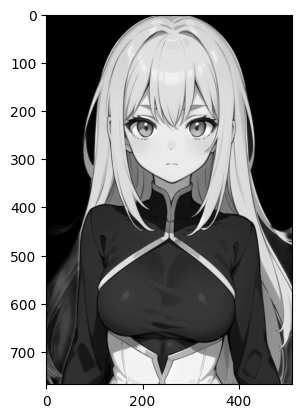

In [13]:
import matplotlib.pyplot as plt
# Display the image in gray:
plt.imshow(train_images[13], cmap='gray')  # Use 'gray' colormap for grayscale images
plt.show()

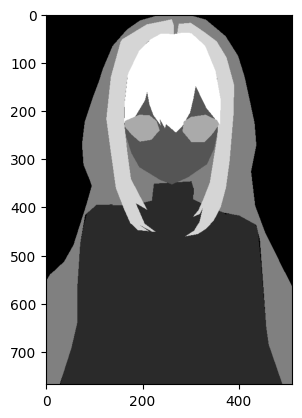

In [14]:
plt.imshow(train_masks[13], cmap='gray')  # Use 'gray' colormap for grayscale images
plt.show()

My dataset is small, so I need to augment it:

- Expand dataset to 2000 images
- Resize them for easier computations

In [15]:
from skimage.transform import resize
import numpy as np
#import imageaug as iaa


augmentation_pipeline = iaa.Sequential([
    iaa.Fliplr(0.5),
    iaa.Flipud(0.5),
    iaa.Rotate((-10, 10)),
])

augmented_images = []
augmented_masks = []

random_indices = np.random.choice(range(len(train_images)), 2000, replace=True)

for idx in random_indices:
    image = train_images[idx]
    mask = train_masks[idx]
    
    # Since the mask is 2D, no transposition is needed
    aug_det = augmentation_pipeline.to_deterministic()
    image_aug = aug_det.augment_image(image)
    mask_aug = aug_det.augment_image(mask.astype(np.uint8))
        
    # Resize both the augmented image and its corresponding mask
    image_aug_resized = resize(image_aug, (384, 256))
    #mask_aug_resized = resize(mask_aug, (384, 256))
    # I need to keep my 7 classes in my mask:
    new_width, new_height = 256, 384
    pil_mask = Image.fromarray(mask_aug.astype(np.uint8))

    resized_pil_mask = pil_mask.resize((new_width, new_height))  # Replace new_width and new_height with desired dimensions

    resized_mask = np.array(resized_pil_mask)

    # Ensure the mask is in the correct format (e.g., uint8 for 8-bit images)
    resized_mask = resized_mask.astype(np.uint8)
    
    augmented_images.append(image_aug_resized)
    augmented_masks.append(resized_mask)

augmented_images = np.array(augmented_images)
augmented_masks = np.array(augmented_masks)

In [16]:
np.unique(augmented_masks)

array([0, 1, 2, 3, 4, 5, 6], dtype=uint8)

In [17]:
display(augmented_images.shape,
        augmented_masks.shape)

(2000, 384, 256)

(2000, 384, 256)

Sanity-check:

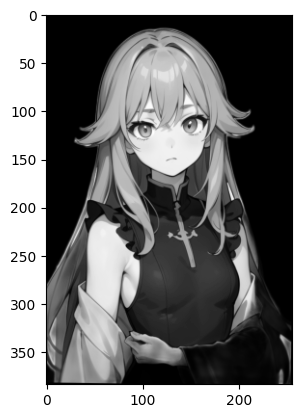

In [18]:
import matplotlib.pyplot as plt
plt.imshow(augmented_images[1], cmap='gray')  # Use 'gray' colormap for grayscale images
plt.show()

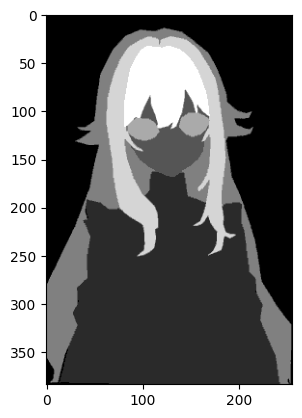

In [19]:
plt.imshow(augmented_masks[1], cmap='gray')  # Use 'gray' colormap for grayscale images
plt.show()

In [20]:
labelencoder = LabelEncoder()
n, h, w = augmented_masks.shape
train_masks_reshaped = augmented_masks.reshape(-1,1)
train_masks_reshaped_encoded = labelencoder.fit_transform(train_masks_reshaped)
train_masks_encoded_original_shape = train_masks_reshaped_encoded.reshape(n, h, w)

np.unique(train_masks_encoded_original_shape)

F:\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([0, 1, 2, 3, 4, 5, 6], dtype=int64)

In [21]:
augmented_images = np.expand_dims(augmented_images, axis=3)
augmented_images = normalize(augmented_images, axis=1)

train_masks_input = np.expand_dims(train_masks_encoded_original_shape, axis=3)

In [22]:
display(augmented_images.shape,
       train_masks_input.shape)

(2000, 384, 256, 1)

(2000, 384, 256, 1)

In [23]:
from sklearn.model_selection import train_test_split
X1, X_test, y1, y_test = train_test_split(augmented_images, train_masks_input, test_size = 0.10, random_state = RANDOM_STATE)

#Further split training data t a smaller subset for quick testing of models
X_train, X_do_not_use, y_train, y_do_not_use = train_test_split(X1, y1, test_size = 0.2, random_state = RANDOM_STATE)

print("Class values in the dataset are ... ", np.unique(y_train))  # 0 is the background/few unlabeled 

Class values in the dataset are ...  [0 1 2 3 4 5 6]


In [24]:
display(X_train.shape,
       X_do_not_use.shape,
       X_test.shape)

(1440, 384, 256, 1)

(360, 384, 256, 1)

(200, 384, 256, 1)

In [25]:
from keras.utils import to_categorical
train_masks_cat = to_categorical(y_train, num_classes=CLASSES)
#y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))

test_masks_cat = to_categorical(y_test, num_classes=CLASSES)
#y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))

In [26]:
display(train_masks_cat.shape,
       test_masks_cat.shape)

(1440, 384, 256, 7)

(200, 384, 256, 7)



---

My dataset is ready for U-Net model

## Model: U-NET
I`ll start with U-Net (64):  


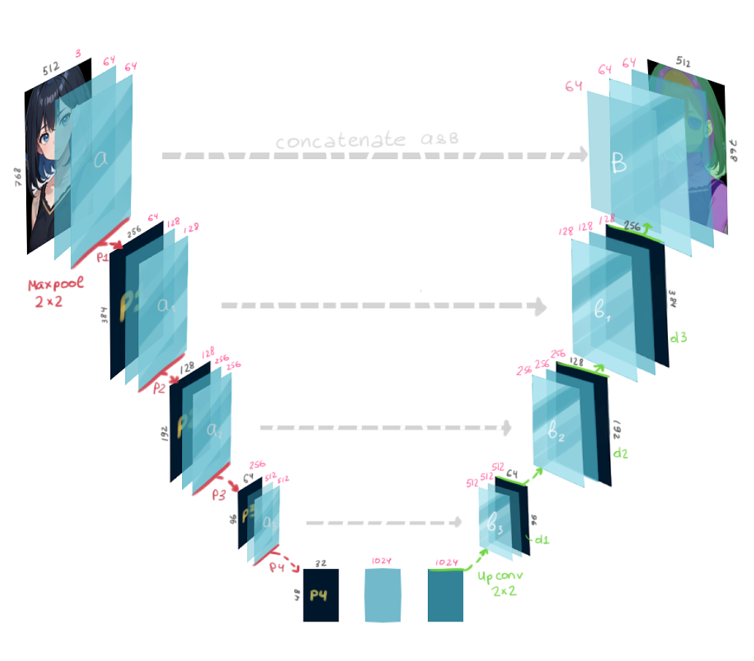

(had to resize input pictures later due to litimations)

In [27]:
def multi_unet_model(n_classes=7, IMG_HEIGHT=384, IMG_WIDTH=256, IMG_CHANNELS=1):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = Lambda(lambda x: x / 255)(inputs)   
    
    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    #Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    
    
    #model.summary()
    
    return model

In [28]:

model = multi_unet_model()

In [29]:
# for dice
def dice_coef(y_pred, y_true):
    y_pred = tf.unstack(y_pred, axis=3)
    y_true = tf.unstack(y_true, axis=3)
    dice_summ = 0

    for i, (a_y_pred, b_y_true) in enumerate(zip(y_pred, y_true)):
        dice_calculate = (2 * tf.math.reduce_sum(a_y_pred * b_y_true) + 1) /\
         (tf.math.reduce_sum(a_y_pred + b_y_true) + 1)

        dice_summ += dice_calculate
    avg_dice = dice_summ/CLASSES
    return avg_dice

def dice_loss(y_pred, y_true):
    d_loss = 1 - dice_coef(y_pred, y_true)
    return d_loss

def dice_bce_loss(y_pred, y_true):
    total_loss = 0.25 * dice_loss(y_pred, y_true) + tf.keras.losses.binary_crossentropy(y_pred, y_true)
    return total_loss

In [30]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [31]:
#model.compile(optimizer='adam',
#              loss=[dice_bce_loss],
#              metrics=[dice_coef])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 384, 256, 1)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lambda (Lambda)               │ (None, 384, 256, 1)       │               0 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d (Conv2D)               │ (None, 384, 256, 16)      │             160 │ lambda[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout (Dropout)             │ (None, 384, 256, 16)      │               0 │ conv2d[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_1 (Conv2D)             │ (None, 384, 256, 16)      │           2,320 │ dropout[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d (MaxPooling2D)  │ (None, 192, 128, 16)      │               0 │ conv2d_1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_2 (Conv2D)             │ (None, 192, 128, 32)      │           4,640 │ max_pooling2d[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_1 (Dropout)           │ (None, 192, 128, 32)      │               0 │ conv2d_2[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_3 (Conv2D)             │ (None, 192, 128, 32)      │           9,248 │ dropout_1[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_1               │ (None, 96, 64, 32)        │               0 │ conv2d_3[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_4 (Conv2D)             │ (None, 96, 64, 64)        │          18,496 │ max_pooling2d_1[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_2 (Dropout)           │ (None, 96, 64, 64)        │               0 │ conv2d_4[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_5 (Conv2D)             │ (None, 96, 64, 64)        │          36,928 │ dropout_2[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_2               │ (None, 48, 32, 64)        │               0 │ conv2d_5[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_6 (Conv2D)             │ (None, 48, 32, 128)       │          73,856 │ max_pooling2d_2[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_3 (Dropout)           │ (None, 48, 32, 128)       │               0 │ conv2d_6[0][0]             │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 1,940,919 (7.40 MB)

 Trainable params: 1,940,919 (7.40 MB)

 Non-trainable params: 0 (0.00 B)

In [32]:
%%time
EPOCHS = 40
BATCH_S = 16


history = model.fit(X_train, train_masks_cat,
                    batch_size = BATCH_S, 
                    verbose=1, 
                    epochs=EPOCHS, 
                    validation_data=(X_test, test_masks_cat), 
                    shuffle=False)

Epoch 1/40
90/90 ━━━━━━━━━━━━━━━━━━━━ 138s 1s/step - accuracy: 0.3558 - loss: 1.7818 - val_accuracy: 0.4105 - val_loss: 1.4366
Epoch 2/40
90/90 ━━━━━━━━━━━━━━━━━━━━ 124s 1s/step - accuracy: 0.4752 - loss: 1.3781 - val_accuracy: 0.6125 - val_loss: 1.1577
Epoch 3/40
90/90 ━━━━━━━━━━━━━━━━━━━━ 125s 1s/step - accuracy: 0.6058 - loss: 1.1602 - val_accuracy: 0.5754 - val_loss: 1.2293
Epoch 4/40
90/90 ━━━━━━━━━━━━━━━━━━━━ 123s 1s/step - accuracy: 0.5943 - loss: 1.2235 - val_accuracy: 0.6147 - val_loss: 1.1336
Epoch 5/40
90/90 ━━━━━━━━━━━━━━━━━━━━ 124s 1s/step - accuracy: 0.6075 - loss: 1.1409 - val_accuracy: 0.6271 - val_loss: 1.0958
Epoch 6/40
90/90 ━━━━━━━━━━━━━━━━━━━━ 124s 1s/step - accuracy: 0.6255 - loss: 1.1138 - val_accuracy: 0.6069 - val_loss: 1.1537
Epoch 7/40
90/90 ━━━━━━━━━━━━━━━━━━━━ 124s 1s/step - accuracy: 0.6200 - loss: 1.1120 - val_accuracy: 0.6884 - val_loss: 0.9653
Epoch 8/40
90/90 ━━━━━━━━━━━━━━━━━━━━ 124s 1s/step - accuracy: 0.6468 - loss: 1.0751 - val_accuracy: 0.6490 - v

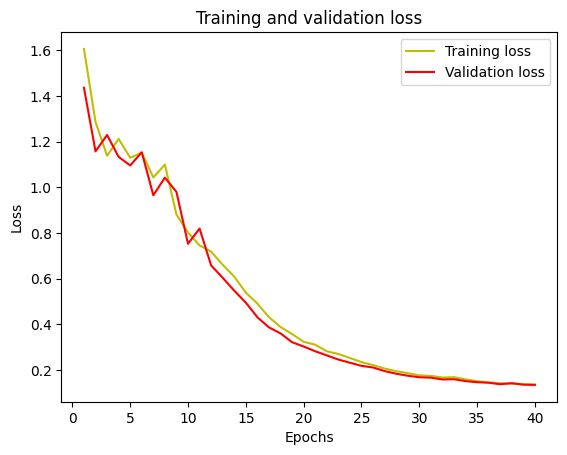

In [33]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

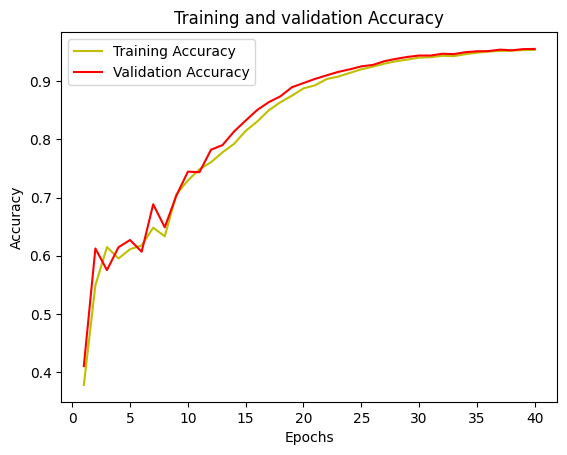

In [34]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [35]:
_, acc = model.evaluate(X_test, test_masks_cat)
print("Accuracy is = ", (acc * 100.0), "%")

7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 527ms/step - accuracy: 0.9555 - loss: 0.1340
Accuracy is =  95.51830887794495 %


In [36]:
prediction = model.predict(X_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 514ms/step


In [37]:
prediction[0].shape

(384, 256, 7)

In [38]:
def display_classes(mask):
    """
    Displays each class of the mask in separate subplots within a single figure.

    Parameters:
    - mask: A 3-dimensional NumPy array representing the mask.
    """
    num_classes = 7   
    list_of_classes=['background', 'body', 'face', 'back_hair', 'eyes', 'hair_front', 'bangs']
    fig, axs = plt.subplots(1, num_classes, figsize=(10, 20*num_classes))
    axs = axs.flatten()


    for i, ax in enumerate(axs):
        class_mask = mask[:,:,i]
        
        ax.imshow(class_mask, cmap='gray')
        ax.set_title(f'Class {list_of_classes[i]}')  
        ax.axis('off')  


    plt.tight_layout()

    plt.show()


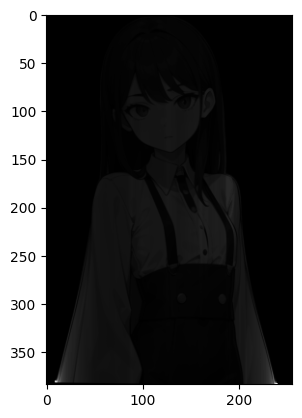

In [39]:
# the image
plt.imshow(X_test[19], cmap='gray')
plt.show()

In [40]:
X_test[19].shape

(384, 256, 1)

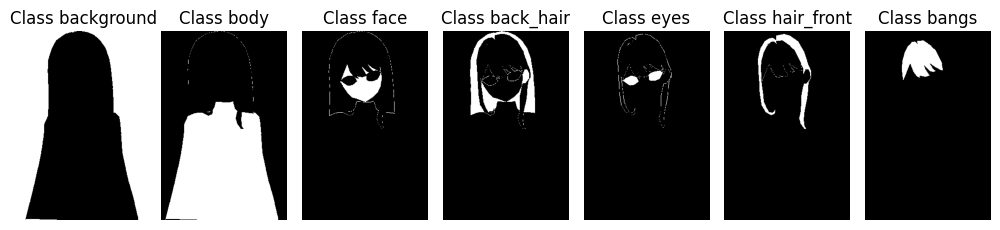

In [41]:
# manually labeled mask
display_classes(test_masks_cat[19])

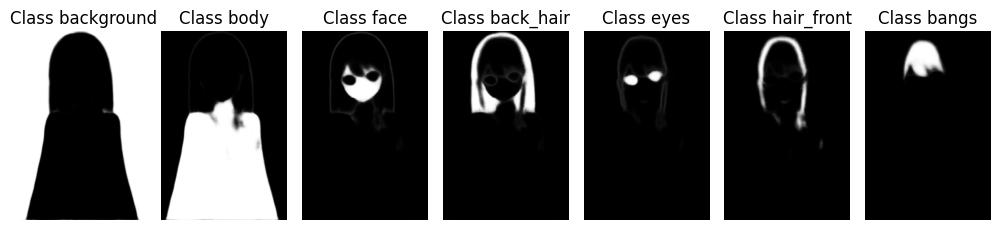

In [42]:
# U-Net generated mask
display_classes(prediction[19])

In [43]:
#saving my model 
model.save(r'path')

## Model testing on original dataset

I`ll final test my model on original dataset (that I augmented later)  
Testing will be done for different number of epochs: 20 30 and 50

In [44]:
test_image_final = []

In [45]:
for i in range(0, 40):
    test_image = resize(train_images[i], (384, 256))
    test_image_final.append(test_image)

In [46]:
test_image_final=np.array(test_image_final)

In [47]:
test_image_final.shape

(40, 384, 256)

In [48]:
test_image_final = np.expand_dims(test_image_final, axis=3)
test_image_final = normalize(test_image_final, axis=1)

In [49]:
test_image_final.shape

(40, 384, 256, 1)

In [50]:
prediction = model.predict(test_image_final)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 154ms/step


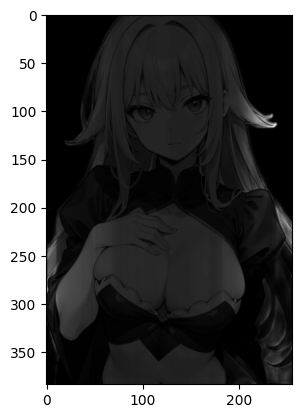

In [51]:
plt.imshow(test_image_final[10], cmap='gray')
plt.show()

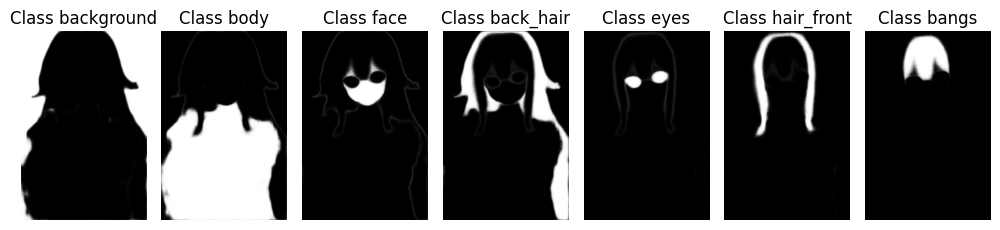

In [52]:
display_classes(prediction[10])

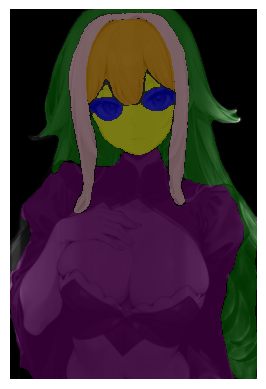

In [53]:
#%%capture
from matplotlib.colors import ListedColormap
import matplotlib.colors as mcolors

transparent_black = mcolors.colorConverter.to_rgba('black', alpha=0)
colormap = ListedColormap([transparent_black, 'red'])

def color_change(i):
    list_of_colors=['black', 'purple', 'yellow', 'green', 'blue', 'pink', 'orange']
    return ListedColormap([transparent_black, list_of_colors[i]])

plt.imshow(test_image_final[10], cmap='gray')


for i in range(0, 7):    
    plt.imshow(prediction[10][:,:,i], cmap=color_change(i), alpha=0.5)

plt.imshow(test_image_final[10], cmap='gray', alpha=0.2)
plt.axis('off')

# Show the plot
plt.show()

**My Model results for 5 epochs (accuracy on validation 70.6%):**

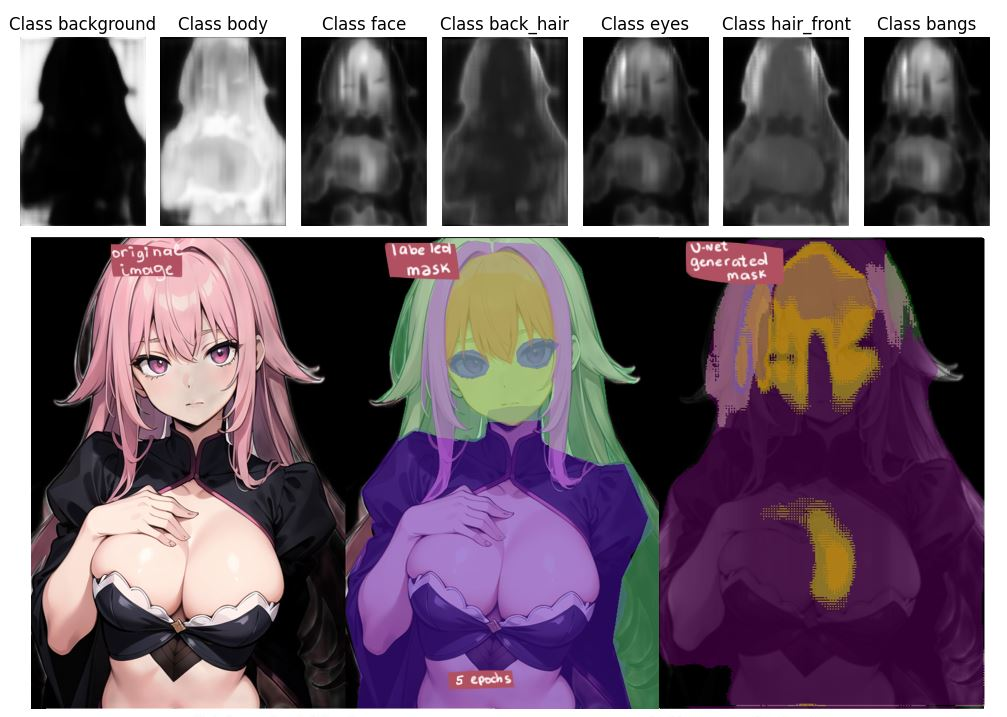

**20 epochs (accuracy=90%):**

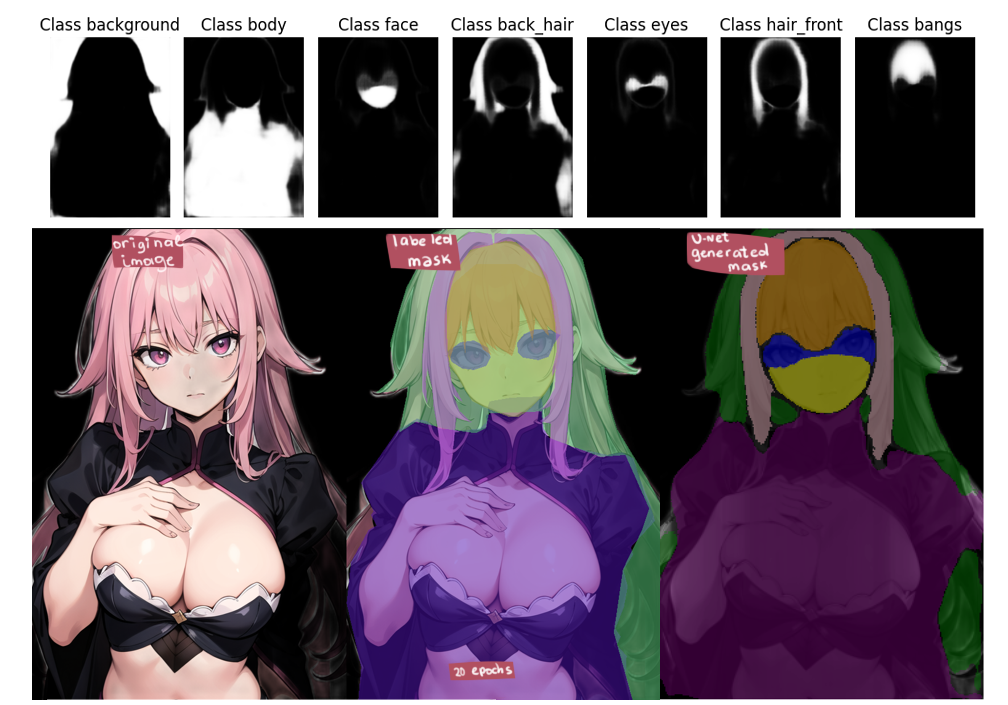

**30 epochs (accuracy=93,9):**

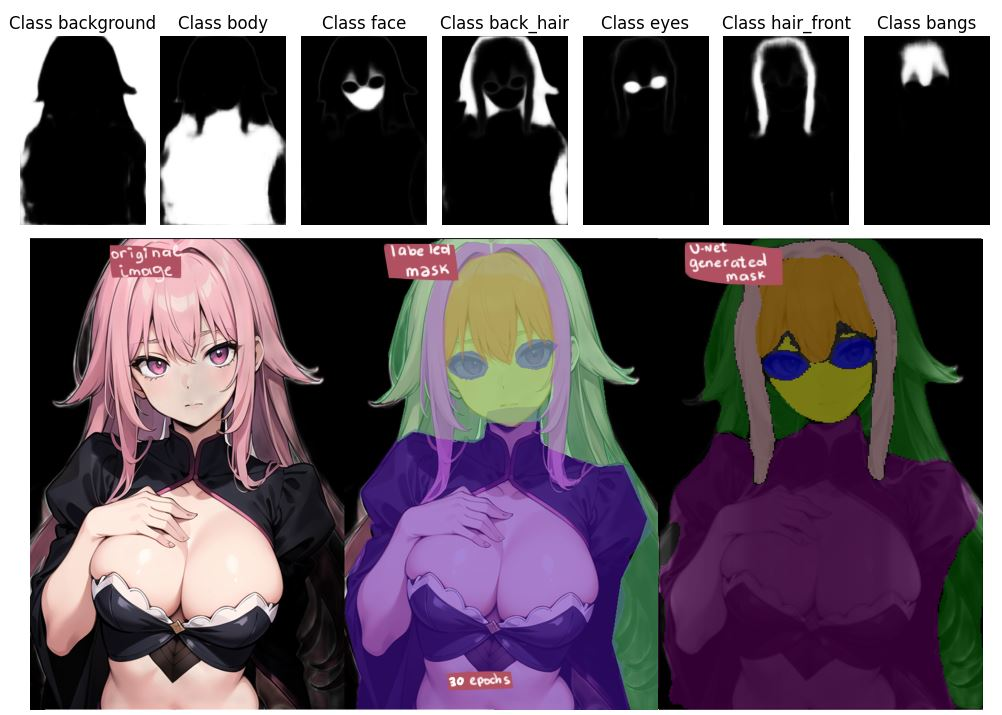

**40 epoches (accuracy=95.5%):**

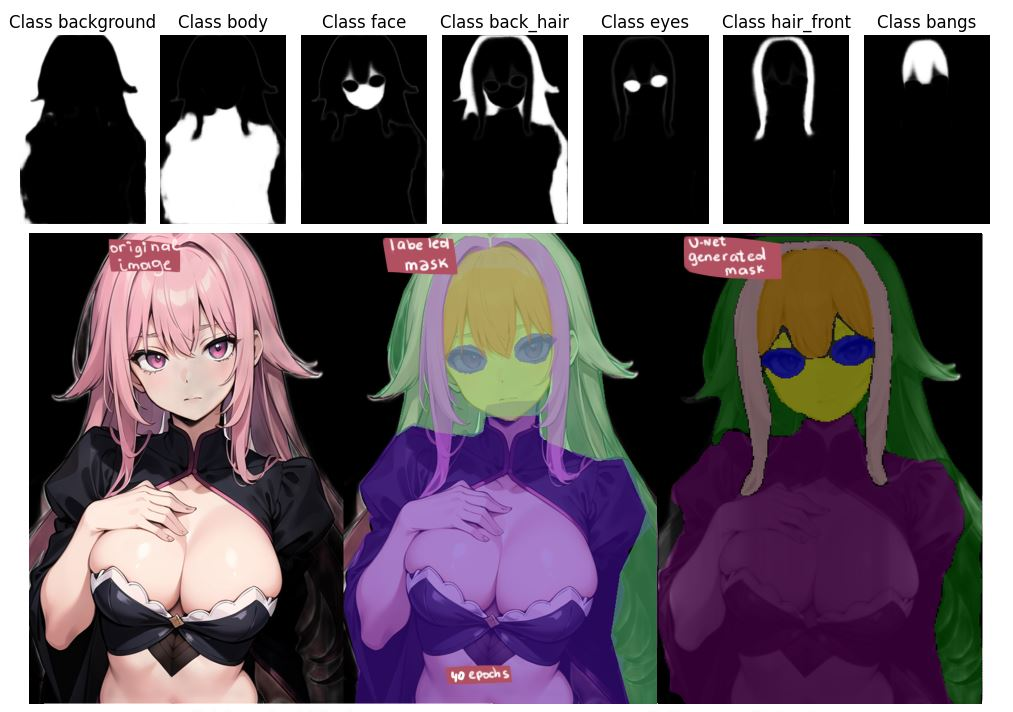

## Picture slicing

Example with gray 

In [134]:
def picture_slicing(image, mask):
    '''
    For cutting images
    '''
    cutted=[]
    for i in range(0, 7):
        mask_cut=mask[:,:,i]
        mask_cut=np.expand_dims(mask_cut, axis=2)
        masked_image = image*mask_cut
        cutted.append(masked_image)
    return cutted

In [135]:
cutted=picture_slicing(test_image_final[10], prediction[10])

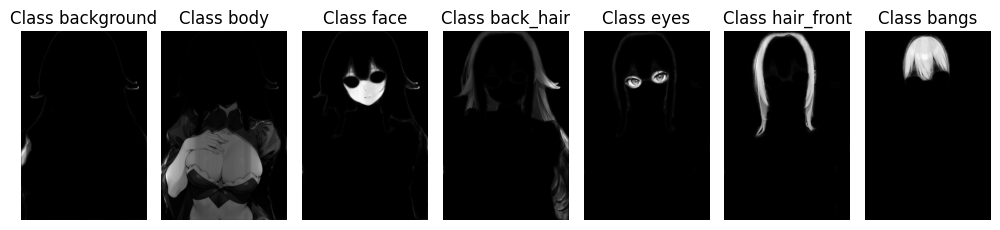

In [136]:
list_of_classes=['background', 'body', 'face', 'back_hair', 'eyes', 'hair_front', 'bangs']
fig, axs = plt.subplots(1, CLASSES, figsize=(10, 20*CLASSES))
axs = axs.flatten()
for i, ax in enumerate(axs):
    class_mask = cutted[i]
        
    ax.imshow(class_mask, cmap='gray')
    ax.set_title(f'Class {list_of_classes[i]}')  
    ax.axis('off')  


plt.tight_layout()

plt.show()

#plt.imshow(cutted[5], cmap='gray')
#plt.show()

Result:...

In [137]:
cv2.imwrite(r"path", cutted[6])

True